# Install Library

In [25]:
# !pip install tensorflow==2.7.0
# !pip install tensorflow-addons==0.15.0
# !pip install opencv-python
# !pip install scikit-learn
# !pip install matplotlib

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.4 MB/s eta 0:00:0000:0100:0

# Define Path

In [20]:
import os


BASE_PATH = os.getcwd() + '/'
IMAGE_PATH = BASE_PATH+"images/"
DATA_PATH = BASE_PATH+"data/"
MODEL_PATH = BASE_PATH+"models/"
MODULE_PATH = BASE_PATH+"modules/"

In [3]:
import sys
sys.path.append(MODULE_PATH)

# Split Dataset

In [ ]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split


# Paths to your dataset
dataset_dir = DATA_PATH + 'source'
images_dir = os.path.join(dataset_dir, 'images')
annotations_dir = os.path.join(dataset_dir, 'annotations')

# Paths for the output directories
output_dir = DATA_PATH
train_images_dir = os.path.join(output_dir, 'train', 'images')
train_annotations_dir = os.path.join(output_dir, 'train', 'annotations')
validation_images_dir = os.path.join(output_dir, 'validation', 'images')
validation_annotations_dir = os.path.join(output_dir, 'validation', 'annotations')

# Create directories if they do not exist
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_annotations_dir, exist_ok=True)
os.makedirs(validation_images_dir, exist_ok=True)
os.makedirs(validation_annotations_dir, exist_ok=True)

# Get a list of all image files and corresponding json files
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')]
json_files = [f for f in os.listdir(annotations_dir) if f.endswith('.json')]

# Ensure that each image has a corresponding json file
image_files = sorted(image_files)
json_files = sorted(json_files)
pairs = [(img, img.replace('.jpg', '.json').replace('.png', '.json')) for img in image_files]

# Split the dataset
train_pairs, validation_pairs = train_test_split(pairs, test_size=0.2, random_state=42)

def copy_files(pairs, image_dest, json_dest):
    for img, json in pairs:
        shutil.copy2(os.path.join(images_dir, img), os.path.join(image_dest, img))
        shutil.copy2(os.path.join(annotations_dir, json), os.path.join(json_dest, json))

# Copy the files to the train and validation directories
copy_files(train_pairs, train_images_dir, train_annotations_dir)
copy_files(validation_pairs, validation_images_dir, validation_annotations_dir)

print("Train-validation split completed successfully!")

In [13]:
import gc


gc.collect()

25

# Data Preprocessing

In [4]:
import os
import json
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


def load_data(image_dir, annotation_dir):
    images = []
    annotations = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.png'):
            img = cv2.imread(os.path.join(image_dir, filename))
            with open(os.path.join(annotation_dir, filename.replace('.png', '.json')), 'r') as f:
                gt = json.load(f)
            images.append(img)
            annotations.append(gt)
    return images, annotations

def preprocess_image(image):
    image = image / 255.0
    return image

def create_mask_and_height_map(image_shape, contours):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    height_map = np.zeros(image_shape[:2], dtype=np.float32)
    for contour in contours:
        points = np.array(contour['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], 1)
        cv2.fillPoly(height_map, [points], contour['group_id'])
    return mask, height_map

def preprocess_data(image_dir, annotation_dir):
    images, annotations = load_data(image_dir, annotation_dir)
    preprocessed_images = [preprocess_image(img) for img in images]
    masks = []
    height_maps = []
    for gt in annotations:
        mask, height_map = create_mask_and_height_map(preprocessed_images[0].shape, gt['shapes'])
        masks.append(mask)
        height_maps.append(height_map)
    return preprocessed_images, masks, height_maps

In [5]:
train_images_dir = DATA_PATH + 'train_100/images'
train_annotations_dir = DATA_PATH + 'train_100/annotations'
train_images, train_masks, train_heights = preprocess_data(train_images_dir, train_annotations_dir)

In [6]:
validation_images_dir = DATA_PATH + 'validation_5/images'
validation_annotations_dir = DATA_PATH + 'validation_5/annotations'
validation_images, validation_masks, validation_heights = preprocess_data(validation_images_dir, validation_annotations_dir)

# Model Training

In [7]:
# def unet_model(input_shape):
#     inputs = tf.keras.Input(input_shape)
#     # Encoder
#     c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
#     p1 = layers.MaxPooling2D((2, 2))(c1)
#     # Decoder
#     u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(p1)
#     u6 = layers.concatenate([u6, c1])
#     c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
#     c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
#     contour_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name='contour_output')(c6)
#     height_output = layers.Conv2D(1, (1, 1), activation='linear', name='height_output')(c6)
#     return models.Model(inputs=[inputs], outputs=[contour_output, height_output])

# input_shape = (512, 512, 3)
# model = unet_model(input_shape)
# model.compile(optimizer='adam', loss={'contour_output': 'binary_crossentropy', 'height_output': 'mean_squared_error'}, metrics=['accuracy'])

In [8]:
import tensorflow as tf
from tensorflow.keras import backend as K


def iou(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)


def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y


def iou_thresholded(y_true, y_pred, threshold=0.5, smooth=1.):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, dtype=y_pred.dtype)  # Cast y_true to the same dtype as y_pred
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)
                                      
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8),
    tf.keras.callbacks.ModelCheckpoint(MODEL_PATH+'model.h5', monitor='val_loss', mode='min', verbose=1, save_weights_only=False, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=6,  mode='min')
]

In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow_addons.optimizers import LazyAdam


def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True, filter_num=64):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = filter_num # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    contour_output = layers.Activation('sigmoid', name='contour_output')(conv_final)
    height_output = layers.Activation('linear', name='height_output')(conv_final)

    # Model integration
    model = models.Model(inputs, [contour_output, height_output], name="AttentionResUNet")
    return model   

if __name__ == "__main__":
    input_shape = (512, 512, 3)
    model = Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.1, batch_norm=True, filter_num=8)
    model.compile(optimizer=LazyAdam(lr=1e-3), 
                  loss={'contour_output': dice_loss, 'height_output': 'mean_squared_error'}, 
                  metrics={'contour_output': [iou, iou_thresholded, tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')], 'height_output': 'accuracy'})
    model.summary()

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 8)  224         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                   

/home/ghiffaryr/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
# Train the model
history = model.fit(
    np.array(train_images), 
    {'contour_output': np.array(train_masks), 'height_output': np.array(train_heights)}, 
    epochs=2, batch_size=4,
    validation_data=(np.array(validation_images), {'contour_output': np.array(validation_masks), 'height_output': np.array(validation_heights)}),
    callbacks=callbacks
)

Epoch 1/2
25/25 [==============================] - ETA: 0s - loss: 161.0531 - contour_output_loss: 0.6459 - height_output_loss: 160.4072 - contour_output_iou: 0.2165 - contour_output_iou_thresholded: 0.2826 - contour_output_recall: 0.7014 - contour_output_precision: 0.3175 - height_output_accuracy: 0.6565
Epoch 00001: val_loss improved from inf to 232.91411, saving model to /mnt/d/Ghiffary/Kuliah/EDISS/BuildingContourDetectionandHeightEstimationProblem/models/model_v1.hdf5


/home/ghiffaryr/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


25/25 [==============================] - 54s 2s/step - loss: 161.0531 - contour_output_loss: 0.6459 - height_output_loss: 160.4072 - contour_output_iou: 0.2165 - contour_output_iou_thresholded: 0.2826 - contour_output_recall: 0.7014 - contour_output_precision: 0.3175 - height_output_accuracy: 0.6565 - val_loss: 232.9141 - val_contour_output_loss: 0.8015 - val_height_output_loss: 232.1126 - val_contour_output_iou: 0.1035 - val_contour_output_iou_thresholded: 1.8819e-05 - val_contour_output_recall: 0.0000e+00 - val_contour_output_precision: 0.0000e+00 - val_height_output_accuracy: 0.8467 - lr: 0.0010
Epoch 2/2
25/25 [==============================] - ETA: 0s - loss: 158.3952 - contour_output_loss: 0.6353 - height_output_loss: 157.7599 - contour_output_iou: 0.2251 - contour_output_iou_thresholded: 0.3233 - contour_output_recall: 0.6783 - contour_output_precision: 0.3832 - height_output_accuracy: 0.6958
Epoch 00002: val_loss did not improve from 232.91411
25/25 [===========================

# Inference and Post-processing

In [8]:
import os
import json
import tensorflow as tf
from tensorflow.keras import backend as K
import cv2
import numpy as np

In [9]:
model = tf.keras.models.load_model(MODEL_PATH+'model.h5', compile=False)

In [ ]:
def preprocess_image(image):
    image = image / 255.0
    return image

def predict_and_generate_output(model, test_image_dir, output_dir):
    image_dir =  [os.path.join(test_image_dir, img) for img in os.listdir(test_image_dir) if img.endswith('.png')]
    test_images = [cv2.imread(path) for path in image_dir]
    test_images = [preprocess_image(img) for img in test_images]
    predictions = model.predict(np.array(test_images))
    contour_preds = predictions[0]
    height_preds = predictions[1]

    for i, img in enumerate(test_images):
        contours, _ = cv2.findContours((contour_preds[i, :, :, 0] > 0.5).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        shapes = []
        for contour in contours:
            contour = contour.squeeze()
            if len(contour.shape) == 1:
                contour = contour[np.newaxis, :]
            points = contour.tolist()
            height = np.mean(height_preds[i][contour[:, 1], contour[:, 0]])
            shape = {
                "label": "building",
                "points": points,
                "group_id": int(height),
                "shape_type": "polygon",
                "flags": {}
            }
            shapes.append(shape)

        output_data = {
            "version": "5.0.1",
            "flags": {},
            "shapes": shapes,
            "imagePath": os.path.basename(image_dir[i]),
            "imageData": None,
            "imageHeight": 512,
            "imageWidth": 512
        }
        
        output_path = os.path.join(output_dir, os.path.basename(image_dir[i]).replace('.png', '.json'))
        with open(output_path, 'w') as outfile:
            json.dump(output_data, outfile)

# Example usage
test_image_dir = DATA_PATH + 'validation_5/images'
test_output_dir = DATA_PATH + 'validation_5/predictions'
predict_and_generate_output(model, test_image_dir, test_output_dir)

In [18]:
# import scorer

In [ ]:
# test_annotations_dir = DATA_PATH + 'validation_5/annotations'
# scorer.main(test_annotations_dir, test_output_dir)

# Visualize

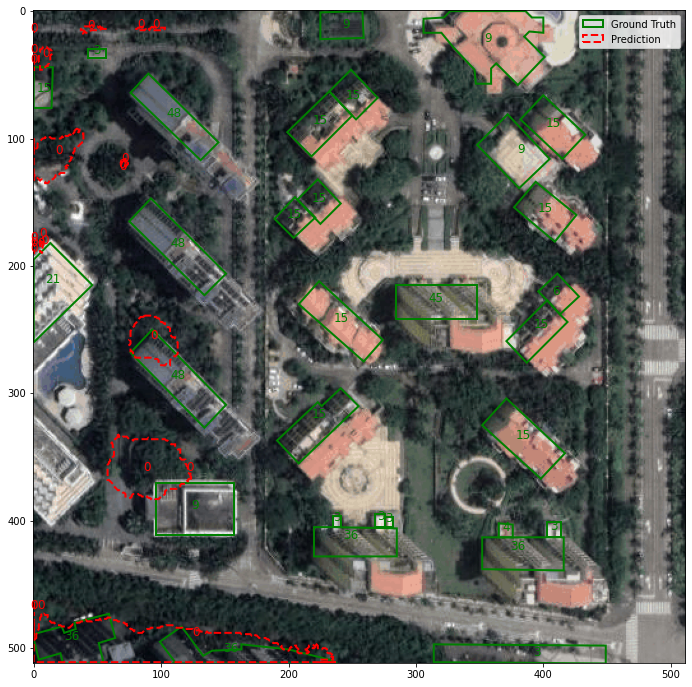

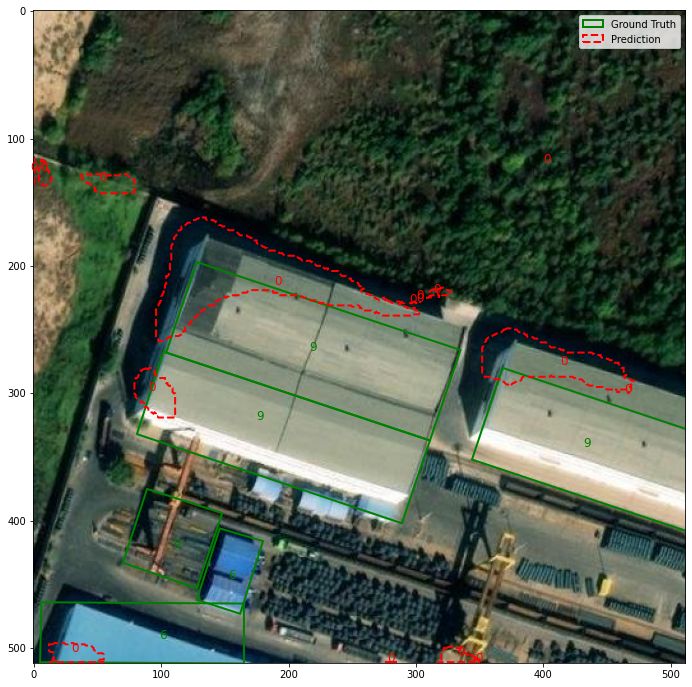

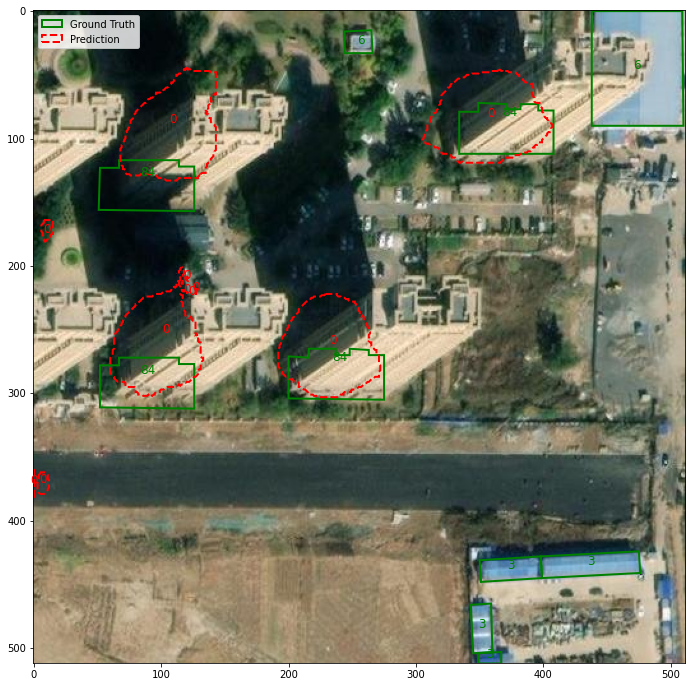

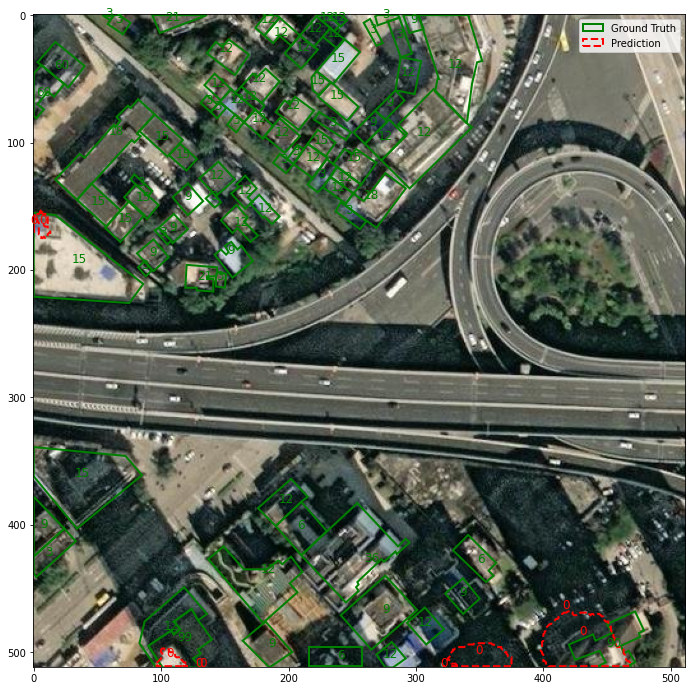

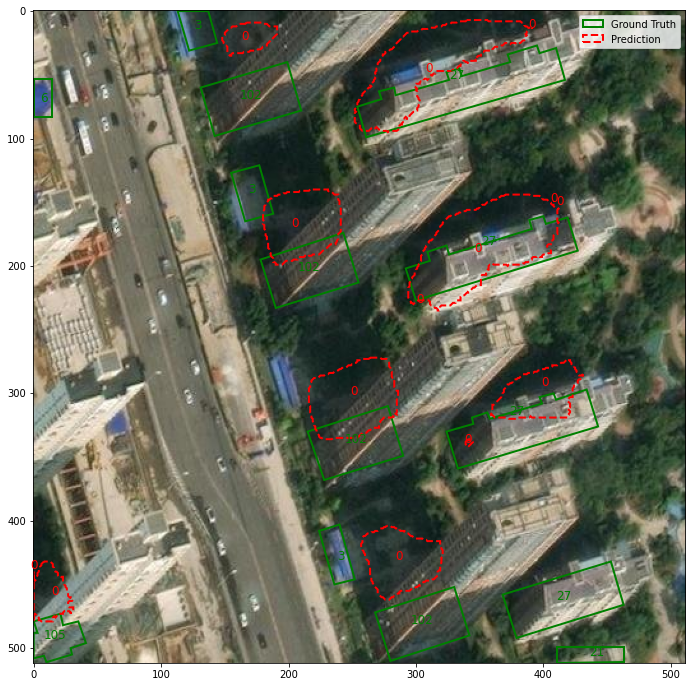

In [18]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import json


def visualize_buildings(image_path, ground_truth, predictions):
    """
    Visualize ground truth and predicted building contours and heights on an image.

    :param image_path: Path to the input image
    :param ground_truth: Ground truth data (list of polygons with heights)
    :param predictions: Predicted data (list of polygons with heights)
    """
    # Load the image
    image = plt.imread(image_path)

    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image)

    # Plot ground truth polygons
    for building in ground_truth:
        polygon = Polygon(building['points'], closed=True, edgecolor='g', facecolor='none', linewidth=2, label='Ground Truth')
        ax.add_patch(polygon)
        centroid = np.mean(building['points'], axis=0)
        ax.text(centroid[0], centroid[1], str(building['height']), color='g', fontsize=12, ha='center')

    # Plot predicted polygons
    for building in predictions:
        polygon = Polygon(building['points'], closed=True, edgecolor='r', facecolor='none', linewidth=2, linestyle='--', label='Prediction')
        ax.add_patch(polygon)
        centroid = np.mean(building['points'], axis=0)
        ax.text(centroid[0], centroid[1], str(building['height']), color='r', fontsize=12, ha='center')

    # Avoid duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    # Show the plot
    plt.show()

def read_buildings_from_json(file_path):
    """
    Read building data from a JSON file.

    :param file_path: Path to the JSON file
    :return: List of buildings with their points and heights
    """
    buildings = []
    with open(file_path) as json_file:
        data = json.load(json_file)
        for shape in data['shapes']:
            building = {
                'points': shape['points'],
                'height': shape['group_id']
            }
            buildings.append(building)
    return buildings

dataset_dir = DATA_PATH + 'validation_5'
for filepath in os.listdir(os.path.join(dataset_dir, 'images')):
    current_file = filepath.split('.')[0]
    
    image_path = dataset_dir + f'/images/{current_file}.png'
    ground_truth_file = dataset_dir + f'/annotations/{current_file}.json'
    prediction_file = dataset_dir + f'/predictions/{current_file}.json'

    ground_truth_buildings = read_buildings_from_json(ground_truth_file)
    predicted_buildings = read_buildings_from_json(prediction_file)

    visualize_buildings(image_path, ground_truth_buildings, predicted_buildings)